In [1]:
import pennylane as qml
import pennylane.numpy as np
import jax.numpy as jnp

import jax
import optax

from time import time
import pickle

import matplotlib.pyplot as plt

import os, sys

parent = os.path.abspath('../src')
sys.path.insert(1, parent)

from perceptron import NativePerceptron
from perceptron import Perceptron

# Set to float64 precision and remove jax CPU/GPU warning
jax.config.update("jax_enable_x64", True)
jax.config.update("jax_platform_name", "cpu")


# Setting up the Problem

In [2]:
# setting up the problem t=100
perceptron_qubits = 4
pulse_basis = 3*perceptron_qubits
ts = jnp.array([1.0])
t = 1

dev = qml.device("default.qubit.jax", wires = perceptron_qubits)


perceptron = NativePerceptron(perceptron_qubits, pulse_basis, basis='fourier', pulse_width=0.005, native_coupling=1)

H =  perceptron.H

H_obj, H_obj_spectrum = perceptron.get_1d_ising_hamiltonian(0.1)

# e_ground_state_exact = H_obj_spectrum[0]

print(f'Ising Model Hamiltonian:\nH = {H_obj}')
# print(f'Exact ground state energy: {e_ground_state_exact}')


Ising Model Hamiltonian:
H =   (0.1) [X0]
+ (0.1) [X1]
+ (0.1) [X2]
+ (0.1) [X3]
+ (1.0) [Z0 Z1]
+ (1.0) [Z1 Z2]
+ (1.0) [Z2 Z3]


I0000 00:00:1718631840.243447       1 tfrt_cpu_pjrt_client.cc:349] TfrtCpuClient created.
/Users/jorgegarciaponce/Research/Yelin/PerceptronLossLandscapes/.venv/lib/python3.11/site-packages/pennylane/ops/functions/eigvals.py:108: UserWarning: For Hamiltonians, the eigenvalues will be computed numerically. This may be computationally intensive for a large number of wires. Consider using a sparse representation of the Hamiltonian with qml.SparseHamiltonian.
  warnings.warn(


In [3]:
perceptron.H

  (1*((PauliZ(wires=[0]) @ PauliZ(wires=[3])) + (PauliZ(wires=[1]) @ PauliZ(wires=[3])) + (PauliZ(wires=[2]) @ PauliZ(wires=[3]))))
+ (fourier_field(params_0, t)*(PauliX(wires=[0])))
+ (fourier_field(params_1, t)*(PauliX(wires=[1])))
+ (fourier_field(params_2, t)*(PauliX(wires=[2])))
+ (fourier_field(params_3, t)*(PauliX(wires=[3])))
+ (fourier_field(params_4, t)*(PauliY(wires=[0])))
+ (fourier_field(params_5, t)*(PauliY(wires=[1])))
+ (fourier_field(params_6, t)*(PauliY(wires=[2])))
+ (fourier_field(params_7, t)*(PauliY(wires=[3])))

In [8]:
V = qml.matrix(qml.evolve(H_obj, 0.1))

@jax.jit
def loss(param_vector):

    param_list = perceptron.vector_to_hamiltonian_parameters(param_vector)

    U = qml.matrix(qml.evolve(perceptron.H)(param_list, t))

    return qml.math.frobenius_inner_product(jnp.conjugate(U-V),U-V).real


In [9]:
perceptron.get_random_parameter_vector(78680)

Array([0.96816285, 0.00801274, 0.34665669, 0.32256784, 0.6049346 ,
       0.28081386, 0.41656109, 0.36925803, 0.50889452, 0.93258732,
       0.30557982, 0.87329949, 0.32640327, 0.22518147, 0.28496659,
       0.48314577, 0.21944009, 0.48400666, 0.16979283, 0.53207712,
       0.10899032, 0.48693023, 0.68885046, 0.35243293, 0.99959555,
       0.39602504, 0.71430782, 0.28669692, 0.67971226, 0.30082839,
       0.06458626, 0.96490327, 0.63978563, 0.47497251, 0.56743426,
       0.60991264, 0.84251787, 0.37617503, 0.35410328, 0.09728239,
       0.9847396 , 0.80121978, 0.27634239, 0.29657509, 0.11233567,
       0.76333083, 0.17963107, 0.03457722, 0.6070128 , 0.54271724,
       0.30316882, 0.27168555, 0.49939806, 0.43614101, 0.38615053,
       0.36849233, 0.16908809, 0.68338032, 0.60753747, 0.42725483,
       0.07739971, 0.16466492, 0.75591138, 0.07606573, 0.63400066,
       0.75184035, 0.71448006, 0.31573379, 0.24156423, 0.90768173,
       0.75602591, 0.55277331, 0.03726156, 0.79720194, 0.99916

In [10]:
# getting the loss_function
# loss = get_loss_function(perceptron, ts, H_obj, dev)

param_vector = perceptron.get_random_parameter_vector(89889)

print(f'Initial parameters: {param_vector}')

print(f'Initial loss: {loss(param_vector)}')

initial_gradients = jax.grad(loss)(param_vector)
print(f'Initial gradients: {initial_gradients}')

value_and_grad = jax.jit(jax.value_and_grad(loss))

Initial parameters: [0.12548551 0.79805219 0.80861378 0.47460721 0.15743329 0.47308654
 0.72475487 0.41240306 0.18287611 0.28751509 0.54042592 0.40924867
 0.49535176 0.35505794 0.97536734 0.34034646 0.77950482 0.20697592
 0.08512638 0.71879666 0.7298648  0.22245487 0.75499679 0.38175023
 0.97934144 0.49629449 0.08459846 0.88307867 0.43753966 0.64010999
 0.70764472 0.31357005 0.16109245 0.86293659 0.38337978 0.66336855
 0.82353941 0.52492017 0.86729782 0.39319351 0.40147245 0.97806251
 0.69089455 0.1614011  0.70471049 0.61839399 0.71508398 0.01975588
 0.16927393 0.47332994 0.50289982 0.67360829 0.41346278 0.06638745
 0.74390634 0.36634877 0.36814736 0.18694213 0.22497791 0.90177329
 0.58830647 0.73487559 0.10329862 0.14512995 0.49898865 0.78450394
 0.20805007 0.15518519 0.40351259 0.13531705 0.81673116 0.16586755
 0.87696266 0.7830036  0.74383749 0.45975368 0.0045005  0.52819953
 0.51280624 0.18682903 0.0440181  0.53221852 0.15941448 0.91803693
 0.75985844 0.9337114  0.70066144 0.837255

TypeError: mul got incompatible shapes for broadcasting: (999,), (12,).

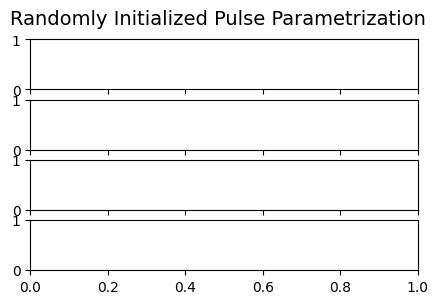

In [11]:
ts = jnp.linspace(0.0, 1, 1000)[:-1]

param_list = perceptron.vector_to_hamiltonian_parameters(param_vector)

fig, axs = plt.subplots(nrows=perceptron_qubits, figsize=(5, 3), sharex=True)  # Adjusted figure size

fig.suptitle('Randomly Initialized Pulse Parametrization', fontsize=14)  # Larger title font

colors = ['teal', 'orange']  # Different colors for different plots

for i in range(perceptron_qubits):
    ax = axs[i]
    ax.plot(ts, perceptron.control_fields[i](param_list[i+perceptron_qubits-1], ts), ".-", color='teal')
    ax.set_ylabel(f"{i} Field", fontsize=10)  # Set label with increased font size

    ax.grid(True)  # Adding gridlines

# Set label for the last plot
axs[-1].set_xlabel("time", fontsize=10)

# plt.tight_layout(rect=[0, 0.03, 1, 0.95])  # Adjust tight_layout to accommodate the suptitle
plt.show()


In [12]:
from datetime import datetime

n_epochs = 2000
param_vector = perceptron.get_random_parameter_vector(54252)


# The following block creates a constant schedule of the learning rate
# # that increases from 0.1 to 0.5 after 10 epochs
# schedule0 = optax.constant_schedule(0.1)
# schedule1 = optax.constant_schedule(0.05)
# # schedule2 = optax.constant_schedule(0.001)
# # schedule = optax.join_schedules([schedule0, schedule1, schedule2], [200, 3000])
# schedule = optax.join_schedules([schedule0, schedule1], [200])

# optimizer = optax.adam(learning_rate=schedule)

# optimizer = optax.adam(learning_rate=0.1)

optimizer = optax.adam(learning_rate=0.01)

# optimizer = optax.sgd(learning_rate=0.005)
# optimizer = optax.adabelief(0.1)
opt_state = optimizer.init(param_vector)

energies = np.zeros(n_epochs )
# energy[0] = loss(param_vector)
mean_gradients = np.zeros(n_epochs)

gradients_trajectory = []
param_trajectory = []

# ## Compile the evaluation and gradient function and report compilation time
# time0 = time()
# _ = value_and_grad(param_vector)
# time1 = time()

# print(f"grad and val compilation time: {time1 - time0}")


## Optimization loop
for n in range(n_epochs):
    val, grads = value_and_grad(param_vector)
    updates, opt_state = optimizer.update(grads, opt_state)

    mean_gradients[n] = np.mean(np.abs(grads))
    energies[n] = val
    param_trajectory.append(param_vector)
    gradients_trajectory.append(grads)

    param_vector = optax.apply_updates(param_vector, updates)

    print(val)

    # if not n % 10:
    #     print(f"{n+1} / {n_epochs}; Frobenius norm: {val}")
    #     print(f"    mean grad: {mean_gradients[n]}")
    #     print(f'    gradient norm: {jnp.linalg.norm(grads)}')
    #     if n>=2:
    #         print(f'    difference of gradients: {jnp.linalg.norm(grads-gradients_trajectory[-2])}')



print(f"Optimal Frobenius Norm Found: {energies[-1]}")


29.967638547594024
29.77629514817533
29.584909828153002
29.393603239469407
29.20259213680968
29.012146878257802
28.82251606681317
28.6339973902066
28.446903058969063
28.261580130972536
28.078396071017725
27.897652208617767
27.71950802122305
27.543977971236885
27.371008397077173
27.20053284824202
27.03245726801059
26.86661545832156
26.70276048565765
26.54060137924087
26.37983509792945
26.22015280942
26.061262819687382
25.90294374582951
25.745087053207932
25.587675084647252
25.4307256359056
25.274268066514313
25.118368091500287
24.963148132730527
24.808763786357908
24.655369081812704
24.503110130260822
24.352108360613027
24.20243291517446
24.054097252988953
23.90709343419004
23.76140412548343
23.616977910640095
23.473721470984913
23.331528231044633
23.19029958057739
23.049948143261176
22.910406383784213
22.77163128847509
22.633586850051135
22.49624261199783
22.359592470165495
22.223656020374037
22.08845405330321
21.954006579751507
21.820337203245316
21.687467999897592
21.555429478630096


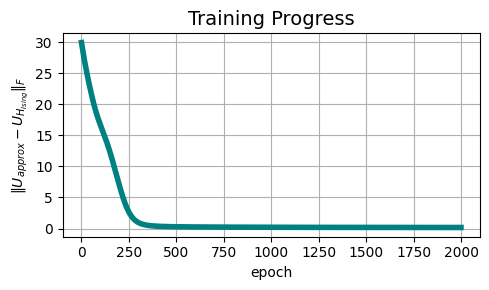

In [11]:
y = energies

fig, ax = plt.subplots(nrows=1, figsize=(5, 3), sharex=True)  # Increased the size for better visibility

ax.set_title('Training Progress', fontsize=14)  # Larger title font
ax.plot(y, color='teal', linestyle='-', linewidth=4)  # Blue line with a solid style and thicker line

ax.set_ylabel("$\| U_{approx} - U_{H_{Ising}} \|_{F}$", fontsize=10)  # Larger font for y-axis label
ax.set_xlabel("epoch", fontsize=10)  # Larger font for x-axis label

ax.grid(True)  # Adding gridlines

plt.tight_layout()
plt.show()


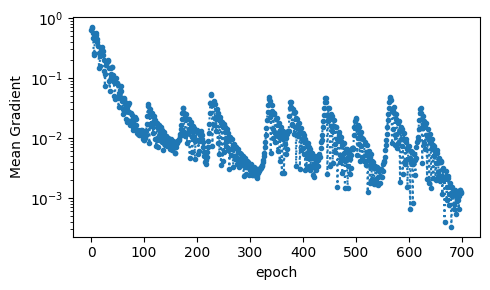

In [ ]:
fig, ax = plt.subplots(nrows=1, figsize=(5, 3), sharex=True)

# y = np.array(energy) - e_ground_state_exact
y = mean_gradients
# ax.plot(y, ".:", label="$\\langle H_{{obj}}\\rangle - E_{exact}$")
ax.plot(y, ".:")
# ax.fill_between([0, len(y)], [1e-3] * 2, 3e-4, alpha=0.2, label="chem acc.")
ax.set_yscale("log")
ax.set_ylabel("Mean Gradient")
ax.set_xlabel("epoch")
# ax.legend()

plt.tight_layout()
plt.show()

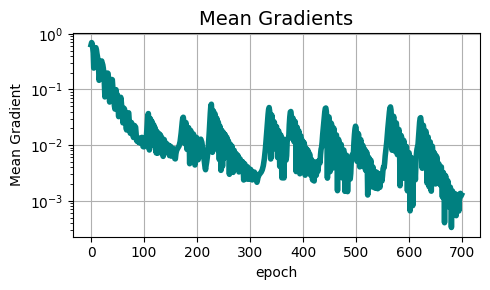

In [ ]:
fig, ax = plt.subplots(nrows=1, figsize=(5, 3), sharex=True)

# Plotting mean_gradients with a style similar to your example
ax.plot(mean_gradients, color='teal', linestyle='-', linewidth=4)  # Adjusted line style and color

ax.set_title('Mean Gradients', fontsize=14)  # Consistent title style
ax.set_yscale("log")  # Logarithmic y-scale
ax.set_ylabel("Mean Gradient", fontsize=10)  # Consistent y-label style
ax.set_xlabel("epoch", fontsize=10)  # Consistent x-label style

ax.grid(True)  # Adding gridlines for better readability

plt.tight_layout()
plt.show()

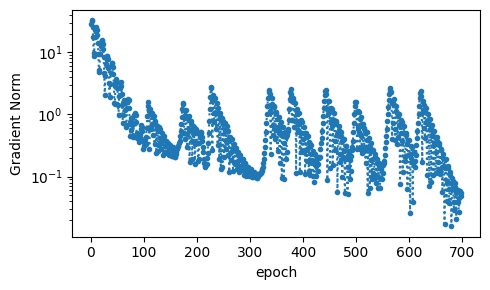

In [ ]:
fig, ax = plt.subplots(nrows=1, figsize=(5, 3), sharex=True)

# y = np.array(energy) - e_ground_state_exact
y = [jnp.linalg.norm(gradient) for gradient in gradients_trajectory]
# ax.plot(y, ".:", label="$\\langle H_{{obj}}\\rangle - E_{exact}$")
ax.plot(y, ".:")
# ax.fill_between([0, len(y)], [1e-3] * 2, 3e-4, alpha=0.2, label="chem acc.")
ax.set_yscale("log")
ax.set_ylabel("Gradient Norm")
ax.set_xlabel("epoch")
# ax.legend()

plt.tight_layout()
plt.show()

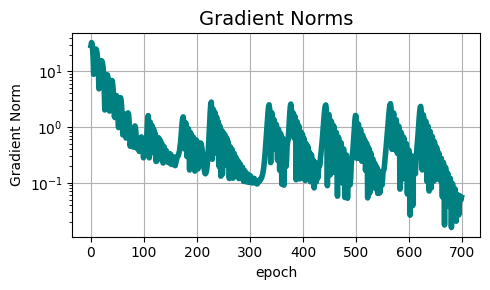

In [ ]:
fig, ax = plt.subplots(nrows=1, figsize=(5, 3), sharex=True)

# y = np.array(energy) - e_ground_state_exact
y = [jnp.linalg.norm(gradient) for gradient in gradients_trajectory]
# ax.plot(y, ".:", label="$\\langle H_{{obj}}\\rangle - E_{exact}$")
ax.plot(y, color='teal', linestyle='-', linewidth=4)  # Consistent style with previous example

ax.set_title('Gradient Norms', fontsize=14)  # Adding a title with a similar style
ax.set_yscale("log")  # Logarithmic scale for y-axis
ax.set_ylabel("Gradient Norm", fontsize=10)  # Consistent y-label style
ax.set_xlabel("epoch", fontsize=10)  # Consistent x-label style

ax.grid(True)  # Adding gridlines for readability

plt.tight_layout()
plt.show()

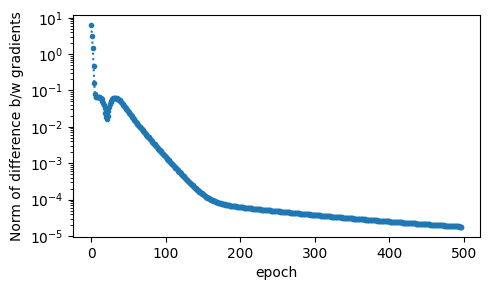

In [ ]:
fig, ax = plt.subplots(nrows=1, figsize=(5, 3), sharex=True)

# y = np.array(energy) - e_ground_state_exact
y = [jnp.linalg.norm(gradients_trajectory[j] - gradients_trajectory[j-1]) for j in range(1,len(gradients_trajectory))]
# ax.plot(y, ".:", label="$\\langle H_{{obj}}\\rangle - E_{exact}$")
ax.plot(y, ".:")
# ax.fill_between([0, len(y)], [1e-3] * 2, 3e-4, alpha=0.2, label="chem acc.")
ax.set_yscale("log")
ax.set_ylabel("Norm of difference b/w gradients")
ax.set_xlabel("epoch")
# ax.legend()

plt.tight_layout()
plt.show()

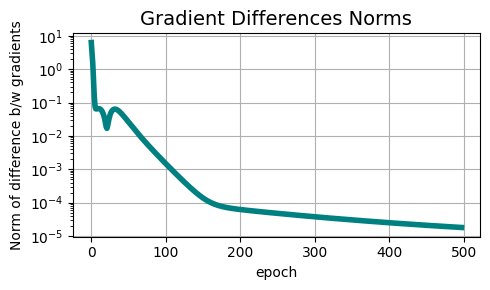

In [ ]:
y = [np.linalg.norm(gradients_trajectory[j] - gradients_trajectory[j-1]) for j in range(1, len(gradients_trajectory))]

fig, ax = plt.subplots(nrows=1, figsize=(5, 3), sharex=True)

# Plotting the norm of difference between gradients
ax.plot(y, color='teal', linestyle='-', linewidth=4)  # Consistent style with previous examples

ax.set_title('Gradient Differences Norms', fontsize=14)  # Adding a title with a similar style
ax.set_yscale("log")  # Logarithmic scale for y-axis
ax.set_ylabel("Norm of difference b/w gradients", fontsize=10)  # Consistent y-label style
ax.set_xlabel("epoch", fontsize=10)  # Consistent x-label style

ax.grid(True)  # Adding gridlines for readability

plt.tight_layout()
plt.show()

TypeError: mul got incompatible shapes for broadcasting: (999,), (12,).

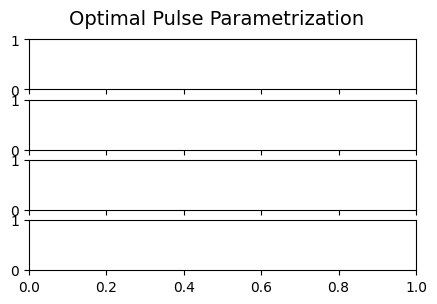

In [ ]:
ts = jnp.linspace(0.0, 1, 1000)[:-1]

param_list = perceptron.vector_to_hamiltonian_parameters(param_vector)

fig, axs = plt.subplots(nrows=perceptron_qubits, figsize=(5, 3), sharex=True)  # Adjusted figure size

fig.suptitle('Optimal Pulse Parametrization', fontsize=14)  # Larger title font

colors = ['teal', 'orange']  # Different colors for different plots

for i in range(perceptron_qubits):
    ax = axs[i]
    ax.plot(ts, perceptron.control_fields[i](param_list[i+perceptron_qubits-1], ts), ".-", color='teal')
    ax.set_ylabel(f"{i} Field", fontsize=10)  # Set label with increased font size

    ax.grid(True)  # Adding gridlines

# Set label for the last plot
axs[-1].set_xlabel("time", fontsize=10)

# plt.tight_layout(rect=[0, 0.03, 1, 0.95])  # Adjust tight_layout to accommodate the suptitle
plt.show()


In [ ]:
# Calculating the Final Hessian

final_hessian = jax.jacrev(jax.jacrev(loss))(param_vector)
final_hessian_eigenvalues = jnp.linalg.eigvals(final_hessian)
final_hessian_eigenvalues

Array([ 3.99669989e+02+0.j,  3.51744416e+02+0.j,  3.17890917e+02+0.j,
        2.95357887e+02+0.j,  2.63675883e+02+0.j,  2.83106930e+02+0.j,
        2.79475098e+02+0.j,  2.06247901e+02+0.j,  2.41160751e+02+0.j,
        2.41318007e+02+0.j,  1.54386158e+02+0.j,  1.58897481e+02+0.j,
        1.06744440e+02+0.j,  1.01240531e+02+0.j,  9.20222838e+01+0.j,
        8.25739199e+01+0.j,  8.12875497e+01+0.j,  7.19839917e+01+0.j,
        7.35936018e+01+0.j,  6.58223638e+01+0.j,  4.78148507e+01+0.j,
        1.72282791e+01+0.j,  1.34399176e+01+0.j,  1.19872739e+01+0.j,
        1.12507176e+01+0.j,  1.09884649e+01+0.j,  8.20450859e+00+0.j,
        5.18592065e+00+0.j,  4.84174257e+00+0.j,  3.71060534e+00+0.j,
        2.15988382e+00+0.j,  1.98853731e+00+0.j,  1.83686523e+00+0.j,
        1.67595107e+00+0.j, -1.15150386e+00+0.j,  1.26137637e+00+0.j,
        1.10070716e+00+0.j,  9.40366136e-01+0.j,  7.44448150e-01+0.j,
        6.76203739e-01+0.j,  4.88849947e-01+0.j,  3.81124488e-01+0.j,
       -3.81600396e-

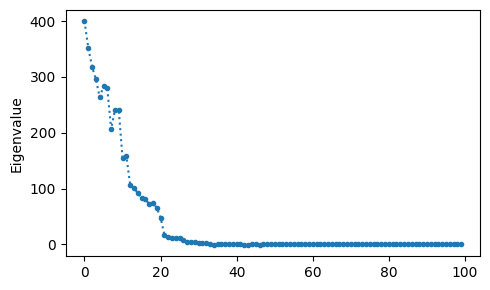

In [ ]:
fig, ax = plt.subplots(nrows=1, figsize=(5, 3), sharex=True)

# y = np.array(energy) - e_ground_state_exact
y = np.linalg.eigvals(final_hessian)

# ax.plot(y, ".:", label="$\\langle H_{{obj}}\\rangle - E_{exact}$")
ax.plot(y, ".:")
# ax.fill_between([0, len(y)], [1e-3] * 2, 3e-4, alpha=0.2, label="chem acc.")
# ax.set_yscale("log")
ax.set_ylabel("Eigenvalue")
# ax.set_xlabel("Eigenvalue")
# ax.legend()
y

plt.tight_layout()
plt.show()

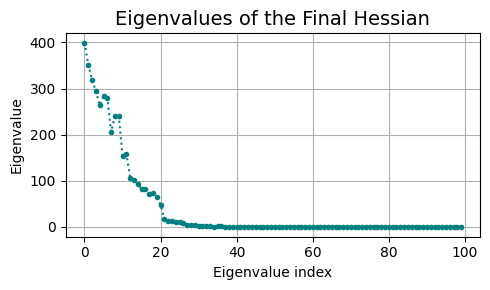

In [ ]:
fig, ax = plt.subplots(nrows=1, figsize=(5, 3), sharex=True)

y = np.linalg.eigvals(final_hessian)

ax.plot(y, ".:", color='teal')  # Use a teal color with a dot-and-dash line style
ax.set_ylabel("Eigenvalue", fontsize=10)  # Set y-axis label with a larger font
ax.set_xlabel("Eigenvalue index", fontsize=10) 
# Uncomment the next line if a log scale is appropriate for your data
# ax.set_yscale("log")

ax.set_title("Eigenvalues of the Final Hessian", fontsize=14)  # Add a title

ax.grid(True)  # Add gridlines

plt.tight_layout()
plt.show()
